In [ ]:
# Import necessary libraries and functions

!pip install -r requirements.txt
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import math

from Bootstrap import (bootstrap, zero_rates, get_dates, build_option_prices, yearfrac)
from Add_Bach_Calibration import * 
from Add_Log_Calibration import *
from Pricing_Exotic import * 
from Hedging import *

Discount Factors: [1.         0.99987732 0.99978502 0.99972659 0.99973297 0.99957055
 0.99986419 1.         1.        ]


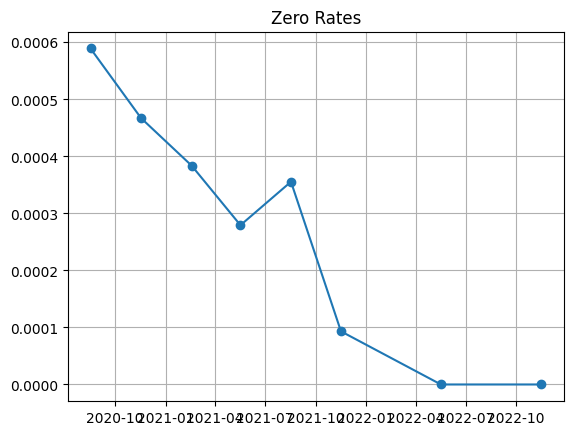

In [2]:
# Main execution block
call_dir = 'datacalls'
put_dir = 'dataputs'
target = 20200602

# Function to build option prices and strikes from the given directories
option_prices, strikes = build_option_prices(call_dir, put_dir, target)
#print("Option Prices:\n", option_prices)
dates = get_dates()

# Bootstrap the option prices to get discount factors and forward prices
disc, fwd_prices = bootstrap(option_prices, strikes)
print("Discount Factors:", disc)
zero_rate_vals = zero_rates(dates[1:], disc[1:], dates[0])

plt.plot(dates[1:], zero_rate_vals, marker='o')
plt.title("Zero Rates")
plt.grid(True)
plt.show()



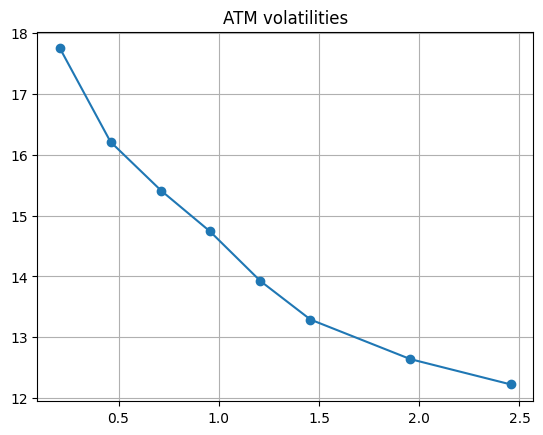

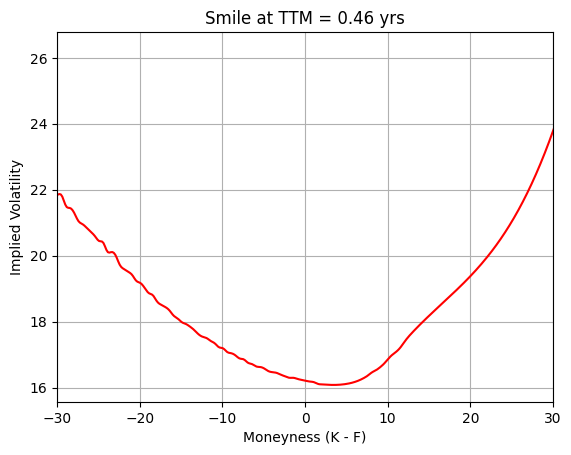

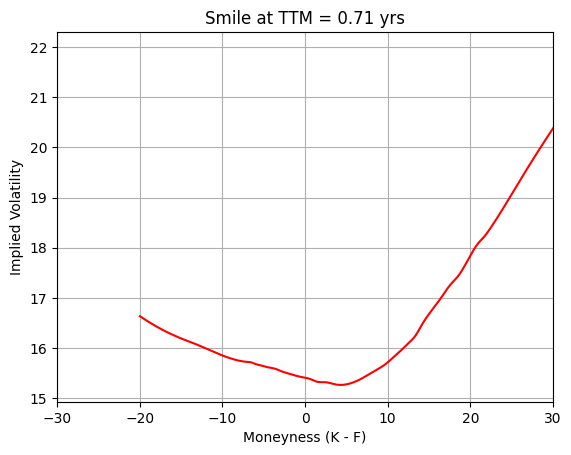

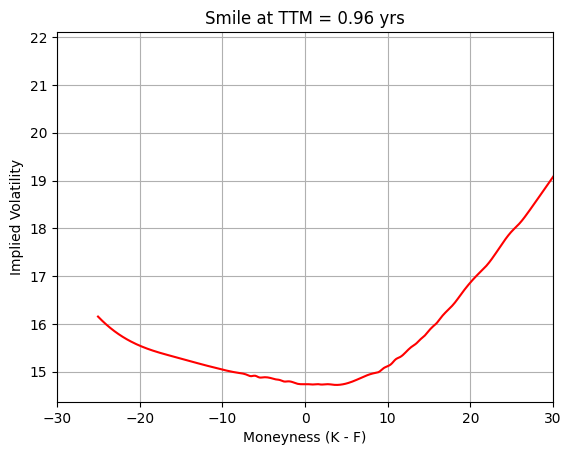

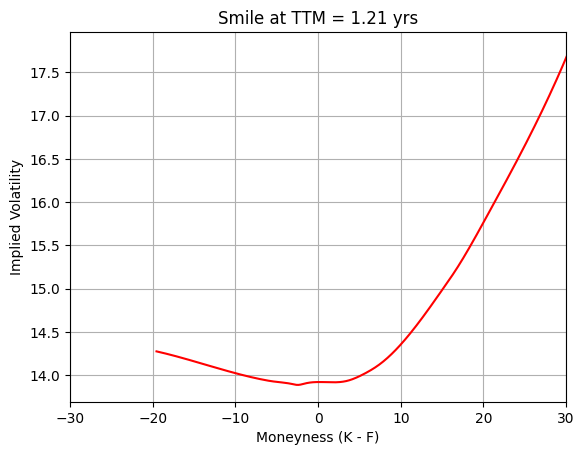

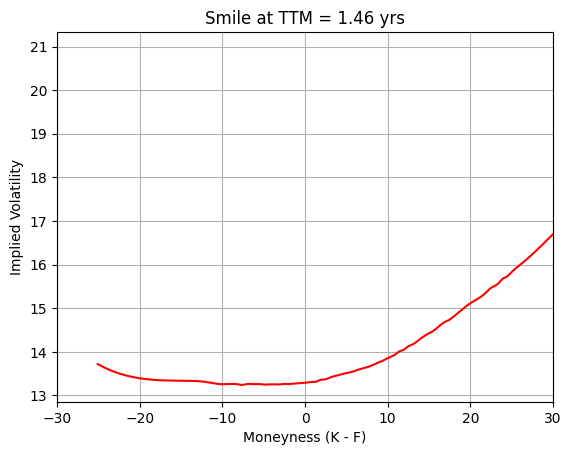

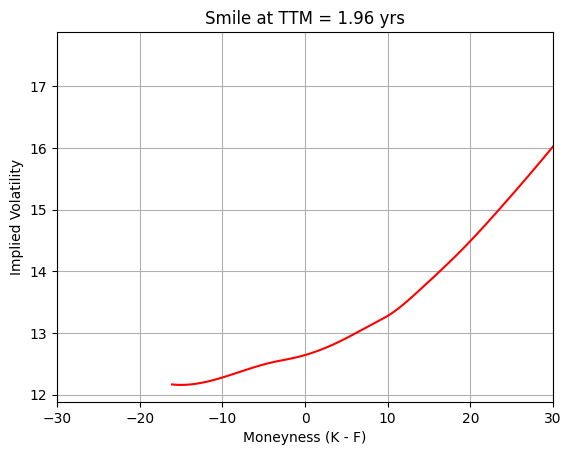

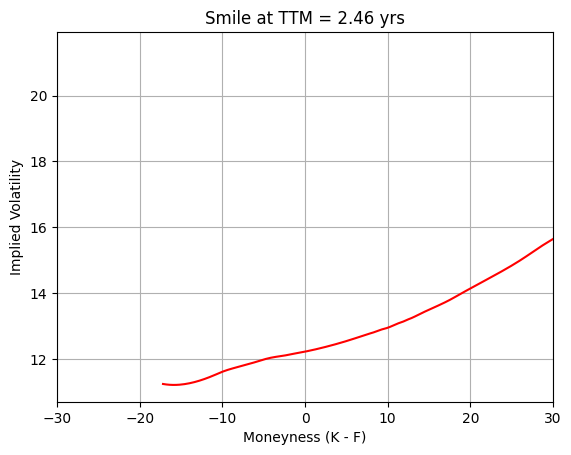

In [3]:
# Calibration of the Additive Bachelier model

# Supponendo che dates, option_prices, strikes, disc, fwd_prices siano già disponibili
ACT_365 = 3
ttm = yearfrac(dates[0], dates[1:], ACT_365)
option_prices_new = put_call_parity(option_prices[2:], strikes, disc, fwd_prices)

np.set_printoptions(threshold=np.inf)
#for row in option_prices_new.T:
#    print(" ".join(f"{val:8.5f}" for val in row))
#    print("\n\n")


sigma_atm = ATMvols(option_prices_new, strikes, fwd_prices, disc, ttm)
implied_vols = market_vols(option_prices_new, strikes, fwd_prices, disc, ttm)

#index=1;
#for row in implied_vols.T:
#    print("Col:", index)
#    index += 1
#    print(" ".join(f"{val:8.5f}" for val in row))
#    print("\n\n")

plt.plot(ttm, sigma_atm, 'o-')
plt.grid(True)
plt.title("ATM volatilities")
plt.show()

plot_vol_smiles(strikes, fwd_prices, implied_vols, ttm)


Additive Bachelier
eta: -0.0679
kappa: 0.6991
--------------


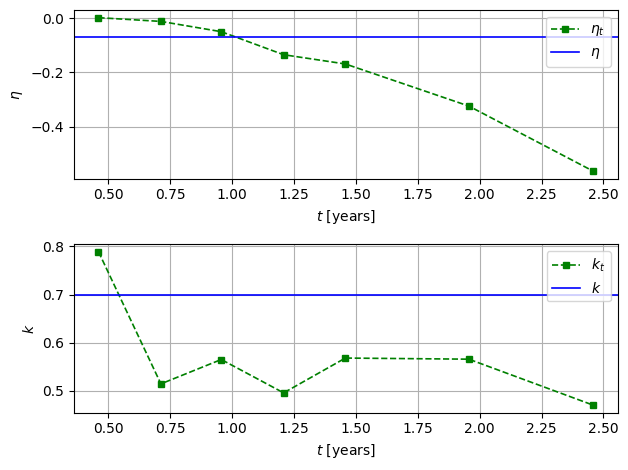

In [4]:
# Additive Bachelier model calibration
# Fixed model parameters
alpha = 1/3
a = 1/3
eta0 = 0.2
k0 = 1

# Calibration with constant eta and k
eta, kappa, I0 = calibrate_add_bach(option_prices_new, sigma_atm, strikes, fwd_prices, ttm, disc, alpha, a, eta0, k0, 1, len(ttm))
print('Additive Bachelier')
print(f'eta: {eta:.4f}')
print(f'kappa: {kappa:.4f}')
print('--------------')

# Rolling calibration
eta_t = np.zeros(len(ttm)-1)
kappa_t = np.zeros(len(ttm)-1)
I0_t = np.zeros(len(ttm)-1)
for i in range(1, len(ttm)):   
    eta_t[i-1], kappa_t[i-1], I0_t[i-1] = calibrate_add_bach(option_prices_new, sigma_atm, strikes, fwd_prices, ttm, disc, alpha, a, eta0, k0, i, i+1)

plot_bachelier_parameters(eta, kappa, eta_t, kappa_t, ttm)

Additive Logistic
Sigma: 7.2500
H: 0.4110
--------------
Optimization terminated successfully.
         Current function value: 584969.491028
         Iterations: 14
         Function evaluations: 28


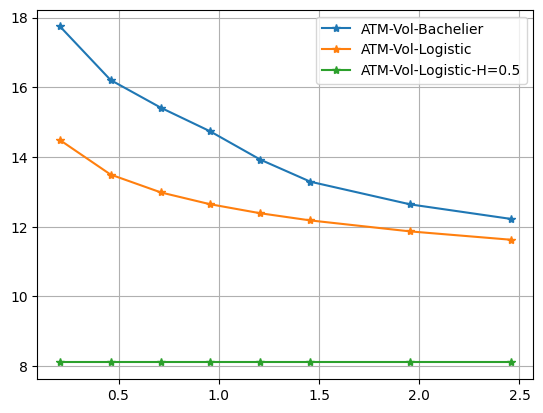

In [5]:
# Additive Logistic model calibration

# Calibrate parameters
sigma, H = calibrate_add_log(strikes, fwd_prices, ttm, option_prices)
print(f"Additive Logistic\nSigma: {sigma:.4f}\nH: {H:.4f}\n--------------")

sigma_h_constant = calibrate_add_log_h_constant(strikes, fwd_prices, ttm, option_prices)

# Calculate sigmaATMLog and sigmaATMLogHConst
s = sigma * ttm**H
sigmaATMLog = s * np.sqrt(2 * np.pi / ttm) * np.log(2)  # H from calibration
s_const = sigma_h_constant * ttm**0.5
sigmaATMLogHConst = s_const * np.sqrt(2 * np.pi / ttm) * np.log(2)  # H = 0.5 fixed in advance

# Plotting
plt.figure()
plt.plot(ttm, sigma_atm, '*-', label='ATM-Vol-Bachelier')
plt.plot(ttm, sigmaATMLog, '*-', label='ATM-Vol-Logistic')
plt.plot(ttm, sigmaATMLogHConst, '*-', label='ATM-Vol-Logistic-H=0.5')

# Adding grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


In [6]:
print(sigma_atm)
print(sigmaATMLog)
print(sigmaATMLogHConst)
print(sigma_h_constant)

[17.74519689 16.2105486  15.41085103 14.74026902 13.92318829 13.29111897
 12.64089743 12.22447626]
Index([14.485476828048803, 13.497634897030732, 12.982828337593244,
        12.64692408868805, 12.386166539134546, 12.180981008515703,
       11.865982278407161, 11.627329858579515],
      dtype='float64')
Index([8.106284014915603, 8.106284014915605, 8.106284014915603,
       8.106284014915605, 8.106284014915607, 8.106284014915603,
       8.106284014915603, 8.106284014915607],
      dtype='float64')
4.66558837890625


In [7]:
# Pricing exotic options using the calibrated models

sigmat = sigma_atm/ I0
ttmlong = np.concatenate(([0], ttm))
Nsim = int(1e7)
increment = np.arange(-100, 100.1, 0.1)
Notional = 20e6
strike = fwd_prices[-1]

priceBac, CIBac = pricing_exotic(strike, disc, ttmlong, fwd_prices, Nsim, increment,
                                eta, kappa, sigmat, alpha, 0, 0, Notional, 'Bac')

priceLog, CILog = pricing_exotic(strike, disc, ttmlong, fwd_prices, Nsim, increment,
                                0, 0, 0, 0, sigma/100, H, Notional, 'Log')

print('Exotic price')
print(f'priceBac: {priceBac}')
print(f'CI Bachelier: [{CIBac[0]}; {CIBac[1]}]')
print(f'priceLog: {priceLog}')
print(f'CI Logistic: [{CILog[0]}; {CILog[1]}]')
print('--------------')


Exotic price
priceBac: 10157468.0
CI Bachelier: [10149323.522484092; 10165612.477515908]
priceLog: 10099272.0
CI Logistic: [10091126.913912913; 10107417.086087087]
--------------


In [8]:
# Hedging
# Step 1 - Hedge the volatility
deltaPriceSigma, sigmat1 = delta_price_volatility(sigma_atm, option_prices_new, strikes, strike, fwd_prices, ttm, ttmlong, disc, alpha, a, eta0, k0, Nsim, increment, priceBac, Notional)
idxTop = pareto_selection(abs(deltaPriceSigma), 0.8)
deltaSigmaTop = deltaPriceSigma[idxTop]  # Most significant price changes
callVolatility = call_volatility_bump(idxTop, fwd_prices, strikes, option_prices_new, sigmat1, ttm, disc, deltaSigmaTop)

# Hedge the delta with futures
futuresInfoVol = hedge_delta_volatility(callVolatility, fwd_prices, sigmat1, ttm, disc)

In [9]:
print(callVolatility)

[[-4.78897911e+05 -3.50474251e+05 -1.84026096e+05]
 [ 3.80000000e+01  4.00000000e+01  3.80000000e+01]
 [ 7.12328767e-01  1.45753425e+00  4.60273973e-01]
 [ 2.00000000e+00  5.00000000e+00  1.00000000e+00]
 [-8.81940000e+04 -5.44210000e+04 -4.24020000e+04]]


In [10]:
# Step 2 - Hedge the skew
bull_info = hedge_eta_bull_spread(strike, strikes, option_prices_new, sigma_atm, ttm, ttmlong, disc, eta, kappa,
                                  sigmat, alpha, fwd_prices, Nsim, increment, Notional, priceBac)

# Extracting relevant information from the result of hedge_eta_bull_spread
delta_bull = bull_info[0] * (deltaOption(bull_info[1], fwd_prices[-1], sigmat[-1], ttm[-1], disc[-1], 'Nan') -
                             deltaOption(bull_info[2], fwd_prices[-1], sigmat[-1], ttm[-1], disc[-1], 'Nan'))

# Calculate futures notional for the skew hedge
n_future_eta = -delta_bull

# Number of futures contracts required for the hedge
number_future_eta = np.ceil(n_future_eta / fwd_prices[-1])


In [11]:
print(bull_info)

[[7.35509872e+05]
 [2.50000000e+01]
 [6.05000000e+01]
 [3.47600000e+04]]


In [12]:
# Step 3 - Hedge the vol-vol
strangle_info = hedge_kappa_strangle(
    strike, strikes, option_prices_new, sigma_atm, ttm, ttmlong, disc,
    eta, kappa, sigmat, alpha, fwd_prices, Nsim, increment, Notional, priceBac
)

# Calcolo della delta dello strangle
delta_str = strangle_info[0] * (
    deltaOption(strangle_info[1], fwd_prices[-1], sigmat[-1], ttm[-1], disc[-1], 'Nan') +
    deltaOption(strangle_info[2], fwd_prices[-1], sigmat[-1], ttm[-1], disc[-1], 'Put')
)

# Numero di future per coprire la vol-vol
n_future_kappa = -delta_str
number_future_kappa = math.ceil(n_future_kappa / fwd_prices[-1])


10157794.0
10157468.0
Call strike: 52.0
Put strike: 32.0
Strangle price (base kappa): 7.628106484967054
Strangle price (shocked kappa): 7.628505524756992
Delta strangle kappa: 0.0003990397899382714, Notional required: -816961.1357564866
95 55
4.11 3.27


In [13]:
print(strangle_info)

[-8.16961136e+05  5.20000000e+01  3.20000000e+01 -1.10699000e+05]


Date: 2020-06-03 00:00:00 | P&L: 1434184.3445936926 | Exotic Price: 10077063.309970494
Date: 2020-06-04 00:00:00 | P&L: 1370501.480962718 | Exotic Price: 10018601.521437364
Date: 2020-06-05 00:00:00 | P&L: 1269485.6684820764 | Exotic Price: 10006510.490844755
Date: 2020-06-08 00:00:00 | P&L: 1303089.2176564205 | Exotic Price: 9989821.270897606
Date: 2020-06-09 00:00:00 | P&L: 1203982.7172113284 | Exotic Price: 9933844.495308585
Date: 2020-06-10 00:00:00 | P&L: 1119120.7496197727 | Exotic Price: 9883650.10824195
Date: 2020-06-11 00:00:00 | P&L: 1252549.9784712885 | Exotic Price: 9911465.488123205
Date: 2020-06-12 00:00:00 | P&L: 1100281.5072991233 | Exotic Price: 9803648.905734979
Date: 2020-06-15 00:00:00 | P&L: 1117710.0184099376 | Exotic Price: 9852789.560252834


/Users/marcodeluca/Desktop/FinalProjectPython/Add_Bach_Calibration.py:56: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  sigma_atm[i] = fsolve(objective, x0=0.2)[0]


Date: 2020-06-16 00:00:00 | P&L: 1044113.0993774049 | Exotic Price: 9836581.360822905
Date: 2020-06-17 00:00:00 | P&L: 1059813.1720003672 | Exotic Price: 9811457.672350323


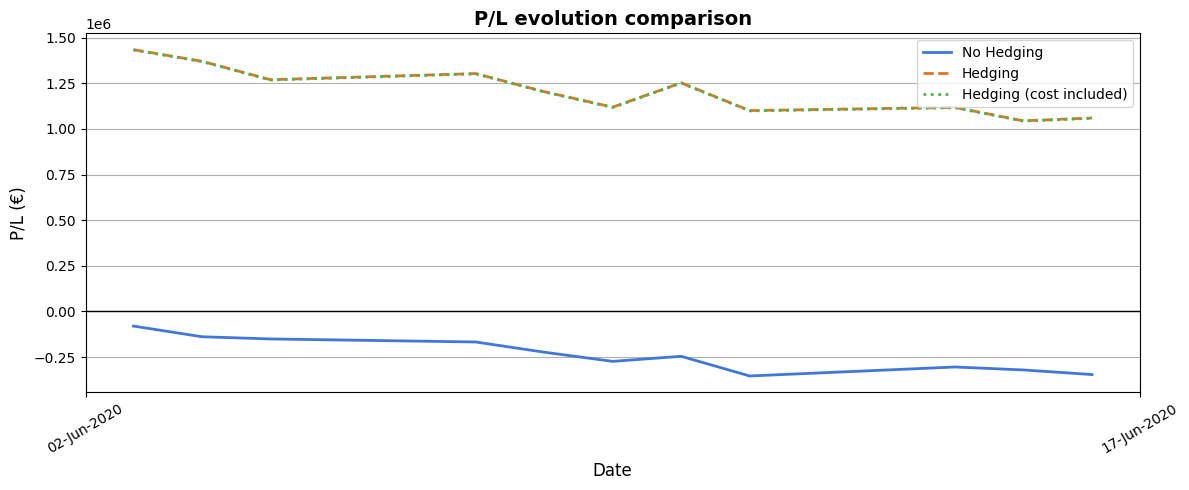

Hedging Quality
PL 9-Jun: 1202386.73
PL 16-Jun: 1042517.11


In [14]:
# Cost Hedging calculation
CostHedging = (
    6e-4 * (np.sum(np.abs(callVolatility[0, :])) + abs(bull_info[0]) + abs(strangle_info[0])) +
    1e-4 * (np.sum(np.abs(futuresInfoVol[0, :])) + abs(n_future_eta) + abs(number_future_kappa))
)

# Portfolio value
ptfValue = (
    priceBac +
    np.sum(np.ceil(callVolatility[0, :])) +
    np.sum(np.ceil(futuresInfoVol[0, :])) +
    np.ceil(bull_info[0]) +
    np.ceil(n_future_eta) +
    np.ceil(strangle_info[0]) +
    np.ceil(number_future_kappa)
)

# Evaluate P&L
targets = targetPL()
dates_PL = datesPL()
PLNoHedging, PLHedging, PLHedgingCost = evaluatePL(
    call_dir, put_dir, targets, dates_PL, alpha,
    a, eta0, k0, Nsim, increment, Notional, callVolatility,
    futuresInfoVol, bull_info, number_future_eta, strangle_info,
    number_future_kappa, ptfValue, CostHedging, priceBac
)

# Plotting P&L (placeholder function)
plotPL(PLNoHedging, PLHedging, PLHedgingCost, dates_PL)

# Output diagnostics
print("Hedging Quality")
print(f"PL 9-Jun: {PLHedgingCost[4]:.2f}")
print(f"PL 16-Jun: {PLHedgingCost[9]:.2f}")
